In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [22]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import numpy as np

In [21]:
pip install -q pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.8 MB/s eta 0:00:00


## Load the DATA

In [57]:
df = pd.read_csv('/content/Alcohol_Sales.csv')

In [58]:
df.describe()

,S4248SM144NCEN
count,325.000000
mean,7886.400000
std,2914.269061
min,3031.000000
25%,5231.000000
50%,7481.000000
75%,9977.000000
max,15504.000000


In [59]:
# df.rename(columns={'S4248SM144NCEN':'Sales'},inplace=True)

In [60]:
df['Date'] = pd.to_datetime(df['DATE'])
df = df.set_index('Date')
df.drop('DATE',axis=1,inplace=True)

In [62]:
df.head()

,Sales
Date,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [56]:
df.head()

,Sales
1992-01-31,3459
1992-02-29,3458
1992-03-31,4002
1992-04-30,4564
1992-05-31,4221


## Ploting the data for the visualization

<Axes: xlabel='Date'>

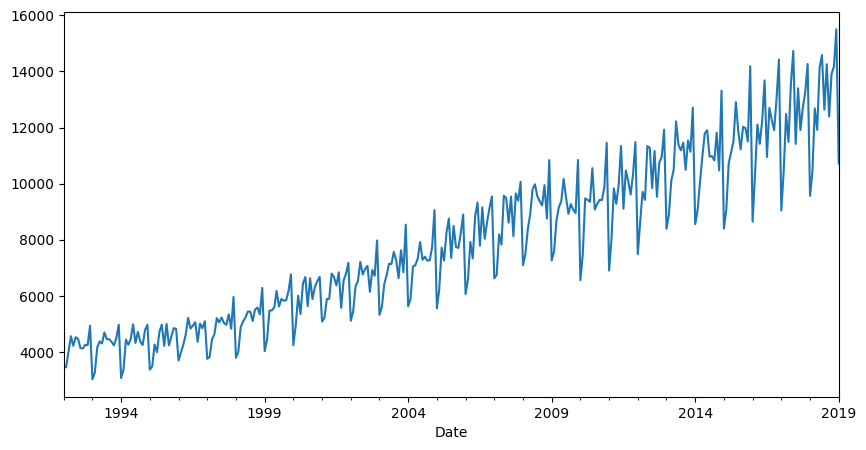

In [40]:
df['Sales'].plot(figsize=(10,5))

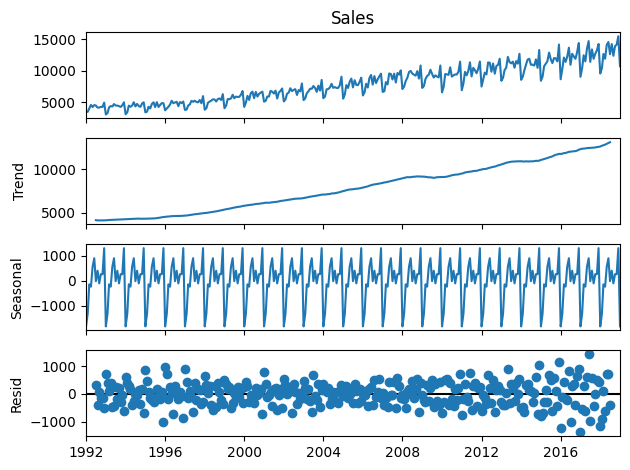

In [41]:
# Decompose the time series (additive or multiplicative)
result = seasonal_decompose(df['Sales'], model='additive', period=12)  # period depends on your data

# Plot the decomposed components
result.plot()
plt.show()

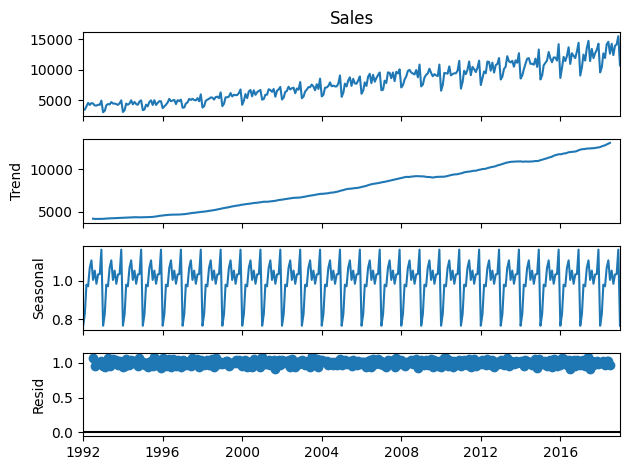

In [42]:
# Decompose the time series (additive or multiplicative)
result = seasonal_decompose(df['Sales'], model='multiplicative', period=12)  # period depends on your data

# Plot the decomposed components
result.plot()
plt.show()

## Check for the Stationary Series


In [43]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(df['Sales'])

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
  print("The series is likely stationary.")
else:
  print("The series is likely non-stationary.")

ADF Statistic: 2.037404725913695
p-value: 0.9987196267088919
Critical Values: {'1%': -3.451621854687657, '5%': -2.870908950689806, '10%': -2.571761810613944}
The series is likely non-stationary.


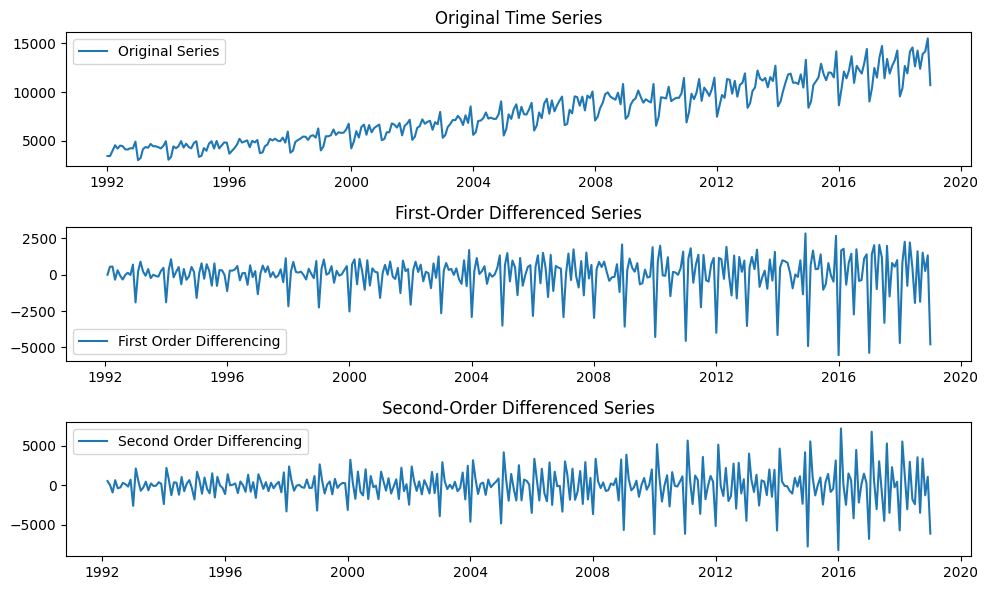

In [44]:
series = df['Sales']

# First-Order Differencing
first_diff = series.diff().dropna()

# Second-Order Differencing
second_diff = first_diff.diff().dropna()

# Plot the original series
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(series, label='Original Series')
plt.title('Original Time Series')
plt.legend()

# Plot the first difference
plt.subplot(3, 1, 2)
plt.plot(first_diff, label='First Order Differencing')
plt.title('First-Order Differenced Series')
plt.legend()

# Plot the second difference
plt.subplot(3, 1, 3)
plt.plot(second_diff, label='Second Order Differencing')
plt.title('Second-Order Differenced Series')
plt.legend()

plt.tight_layout()
plt.show()

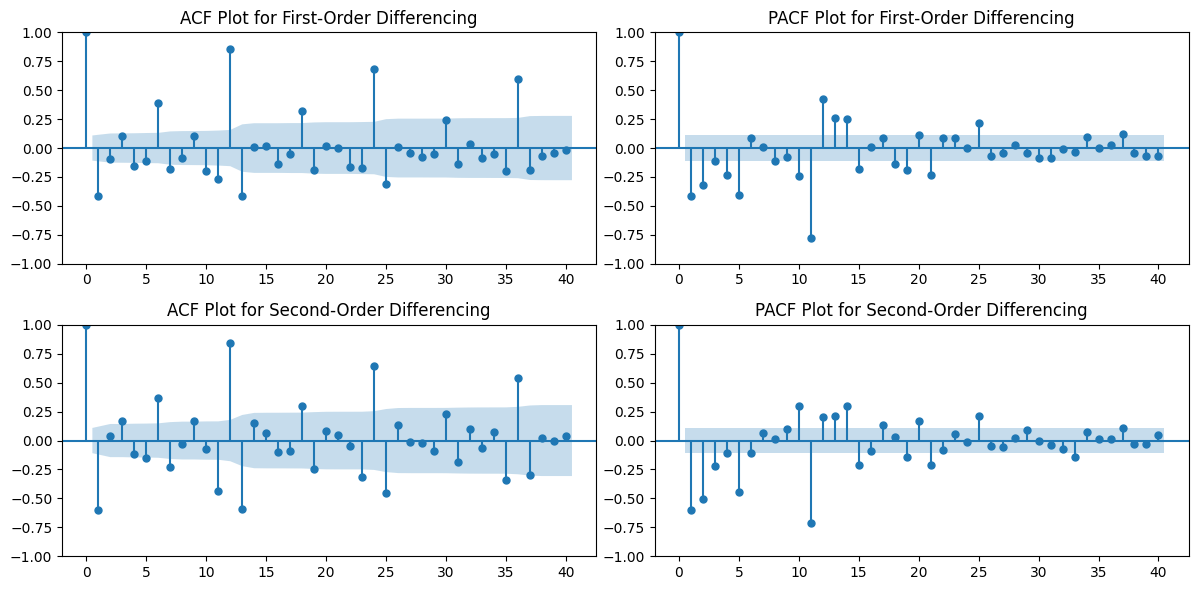

In [45]:

# ACF and PACF plots for First-Order Differencing
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plot_acf(first_diff, lags=40, ax=plt.gca())
plt.title('ACF Plot for First-Order Differencing')

plt.subplot(2, 2, 2)
plot_pacf(first_diff, lags=40, ax=plt.gca())
plt.title('PACF Plot for First-Order Differencing')

# ACF and PACF plots for Second-Order Differencing
plt.subplot(2, 2, 3)
plot_acf(second_diff, lags=40, ax=plt.gca())
plt.title('ACF Plot for Second-Order Differencing')

plt.subplot(2, 2, 4)
plot_pacf(second_diff, lags=40, ax=plt.gca())
plt.title('PACF Plot for Second-Order Differencing')

plt.tight_layout()
plt.show()

## Train and Test data

In [63]:
# Split the data into train and test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [64]:
# Step 1: Use auto_arima to find the best SARIMA model parameters
sarima_model = auto_arima(train['Sales'],
                          start_p=1, start_q=1,
                          max_p=12, max_q=12,
                          m=12,                # Seasonality (12 months if monthly data)
                          start_P=0, seasonal=True,
                          d=None, D=1,          # Automatically test the differencing order
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True,
                          information_criterion='aic')

# Step 2: Print the best SARIMA model parameters
print(f"Best SARIMA model: {sarima_model.summary()}")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3579.335, Time=0.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3796.917, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3693.610, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3595.547, Time=0.95 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3577.336, Time=0.27 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3579.336, Time=0.56 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3557.625, Time=1.97 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=3520.869, Time=3.94 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=3558.823, Time=1.53 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=3471.845, Time=8.52 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=3541.173, Time=3.68 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=10.09 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=5.02 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=inf, Time=9.68 sec
 ARIMA(1,1,2)(2,1,2)[12]         

In [65]:
sarima_model_fit = SARIMAX(train['Sales'],
                           order=sarima_model.order,
                           seasonal_order=sarima_model.seasonal_order).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Prediction , Error calculation and Forecast

In [66]:
forecast_steps = len(test) + 12  # Forecast for test length + 12 months
forecast = sarima_model_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()
forecast_values = forecast.predicted_mean
forecast_index = pd.date_range(start=test.index[0], periods=forecast_steps, freq='MS')

In [67]:

y_true = test['Sales']
y_pred = forecast_values[:len(test)]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse}")

RMSE: 467.04877174610954


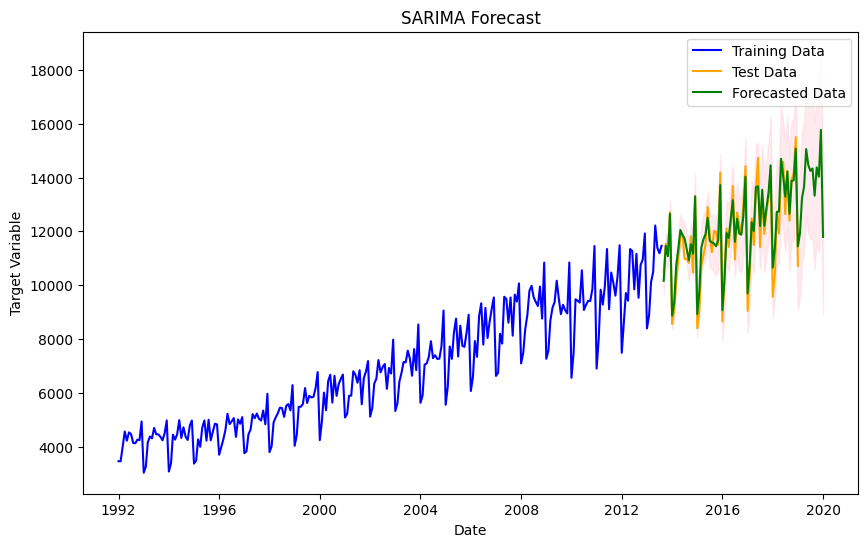

In [68]:
plt.figure(figsize=(10, 6))

# Plot original series and forecast
plt.plot(train.index, train['Sales'], label='Training Data', color='blue')
plt.plot(test.index, test['Sales'], label='Test Data', color='orange')
plt.plot(forecast_index, forecast_values, label='Forecasted Data', color='green')

# Plot forecast confidence intervals
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()



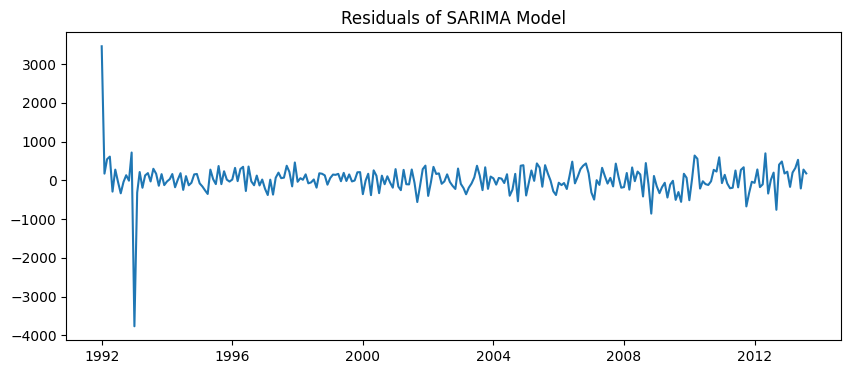

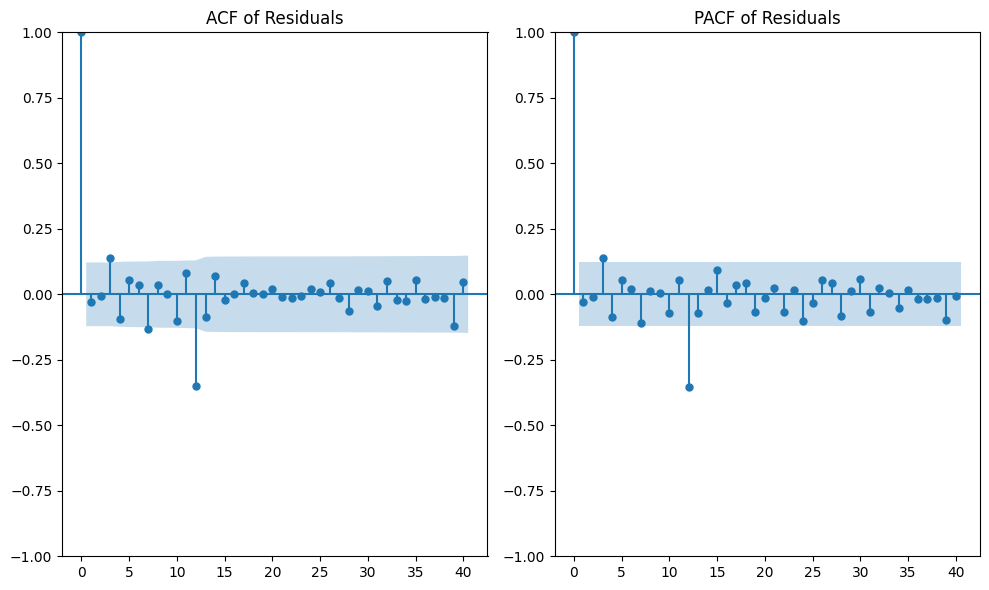

In [71]:
# Plot residuals
residuals = sarima_model_fit.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.title('ACF of Residuals')

plt.subplot(1, 2, 2)
plot_pacf(residuals, ax=plt.gca(), lags=40)
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()


## Save the trained model and also load for the forecast

In [72]:
from joblib import dump, load
# Save the trained model
dump(sarima_model_fit, 'sarima_model.pkl')



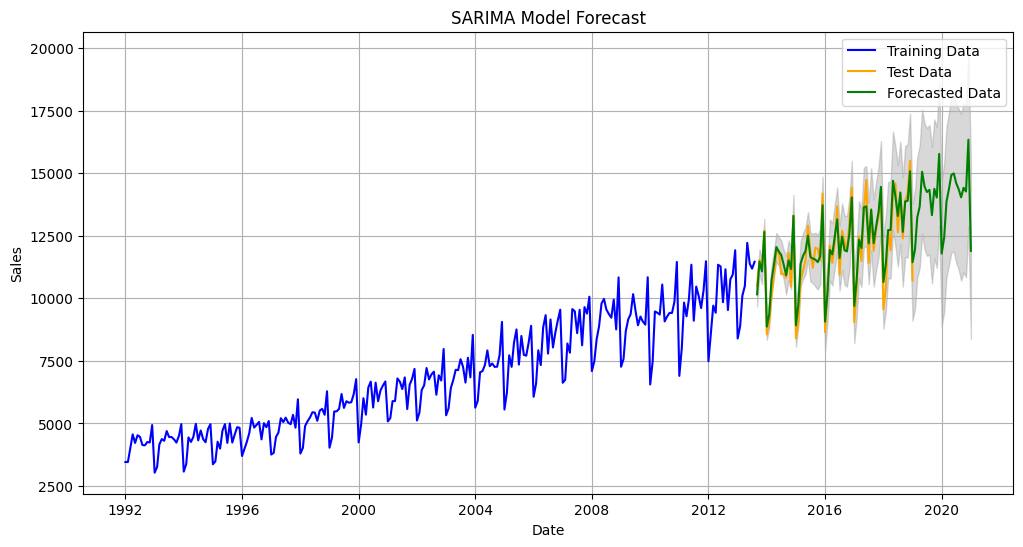

In [79]:
# To load the model later
loaded_model = load('sarima_model.pkl')

#Make predictions
forecast_steps = len(test)+24  # Forecast for the length of the test set
forecast = loaded_model.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
forecast_index = pd.date_range(start=test.index[0], periods=forecast_steps, freq='MS')
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Training Data', color='blue')
plt.plot(test.index, test['Sales'], label='Test Data', color='orange')
plt.plot(forecast_index, forecast_values, label='Forecasted Data', color='green')

# Plot forecast confidence intervals
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='gray', alpha=0.3)

plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()